# HAWC+: Photometry


## Introduction

This recipe provides an overview and sample python code for performing photometry on HAWC+ imaging data.  The HAWC+ observing modes are described in the SOFIA Observer’s Handbooks, available from the [Proposing and Observing  page on the SOFIA website](https://www.sofia.usra.edu/researchers/proposing-and-observing); and the HAWC+ data products are described in the [HAWC+ GO Data Handbook](https://www.sofia.usra.edu/sites/default/files/Instruments/HAWC_PLUS/Documents/HAWC_GO_Handbook_RevB.pdf).  

The instrument can be used in two different modes for imaging:
- traditional chop-nod mode; 
- and slow scanning mode without chopping.
The scanning mode is most often used for total intensity mapping.  The HAWC+ pipeline at the SSC provides the same Level 3 (flux calibrated) data products for both modes, though obviously the algorithms used in each case will be quite different.  See the [HAWC+ GO Data Handbook](https://www.sofia.usra.edu/sites/default/files/Instruments/HAWC_PLUS/Documents/HAWC_GO_Handbook_RevB.pdf) for details regarding the artifacts, pipeline algorithms, and the flux-calibration process.  

(MG:  SOMETHING ON CRUSH?)

Data pipelined from a single flight is marked as Level 3.  Data pipelined from multiple flights are marked as Level 4, but otherwise the two Levels are identical.  

Level 3/4 HAWC+ data is written in FITS format with multiple image and binary table extensions.  The primary HDU contains the flux-calibrated image in Jy per pixel; the following three image HDUs contain the exposure, noise, and S/N maps.  The remainder of the FITS file may contain binary tables that include the raw data scans

Chop-Nod mode Level 3/4 data will have the "CAL" identifier in the filename, whereas the scan mode Level 3/4 data will have "CRH" in the filename.  Otherwise the datafiles are identical in content (TBC!!) and hence the procedures in this recipe can be used for both types.

## Ingredients

1. Level 3 (flux calibrated) HAWC+ imaging data (either CAL or CRH files) from the [SOFIA Science Archive](https://dcs.arc.nasa.gov/dataRetrieval/SearchScienceArchiveInfoBasic.jsp).
    - Sample data is included with this recipe in the hawc-sample-data folder.
2. [HAWC+ GO Handbook](https://www.sofia.usra.edu/sites/default/files/USpot_DCS_DPS/Documents/FORCAST_GO_HAndbook_RevC.pdf) for reference (latest version can be found on the [SOFIA Data Products](https://www.sofia.usra.edu/science/proposing-and-observing/data-products) page.)
3. For this recipe, we require the standard [numpy/scipy/matplotlib stack](https://scipy.org/install.html) as well the following modules:
    - [astropy](http://docs.astropy.org/en/stable/)
    - [aplpy](https://aplpy.readthedocs.io/en/stable/index.html)
    - [photutils](https://photutils.readthedocs.io/en/stable/index.html)

## Viewing the FITS Header

First we will read a FITS file for one of the observations (band C in the sample data), display the full header, and then pick out some important keyword values to display in a "summary" table.

In [1]:
from astropy.io import fits

file_path = 'hawc-sample-data/F0441_HA_IMA_0501652_HAWCHWPOpen_CRH_096-107.fits'

data_fits = fits.open(file_path)
data_fits.info()

Filename: hawc-sample-data/F0441_HA_IMA_0501652_HAWCHWPOpen_CRH_096-107.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY IMAGE    1 PrimaryHDU     566   (271, 289)   float32   
  1  EXPOSURE      1 ImageHDU       412   (271, 289)   float32   
  2  NOISE         1 ImageHDU       412   (271, 289)   float32   
  3  S/N           1 ImageHDU       412   (271, 289)   float32   
  4  SCAN-2017-10-18_HA_F441-05_0165_2-096    1 BinTableHDU    177   1R x 7C   [1J, 1D, 1J, 1D, 1D, 1D, 1D]   
  5  SCAN-2017-10-18_HA_F441-05_0165_2-097    1 BinTableHDU    177   1R x 7C   [1J, 1D, 1J, 1D, 1D, 1D, 1D]   
  6  SCAN-2017-10-18_HA_F441-05_0165_2-098    1 BinTableHDU    177   1R x 7C   [1J, 1D, 1J, 1D, 1D, 1D, 1D]   
  7  SCAN-2017-10-18_HA_F441-05_0165_2-099    1 BinTableHDU    176   1R x 7C   [1J, 1D, 1J, 1D, 1D, 1D, 1D]   
  8  SCAN-2017-10-18_HA_F441-05_0165_2-100    1 BinTableHDU    176   1R x 7C   [1J, 1D, 1J, 1D, 1D, 1D, 1D]   
  9  SCAN-2017-10-18_HA_F441-05_0165_2-

Here you can see the 4 images included in the dataset along wiht supplementary scan data stored as binary tables. Note that the **EXPOSURE** map is in seconds, and the **NOISE** map is standard deviation in Jy.

Now display the full header and then some selected keywords:

In [2]:
#Now display FITS header in full:
data_fits[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  271                                                  
NAXIS2  =                  289                                                  
EXTEND  =                    T                                                  
FILTER  = '89um    '           / rowstart,rowend,colstart,colend                
MCEMAP  = '0,2,1,-1'           / Mapping from hardware MCEs to data             
DATASRC = 'astro   '           / data source category.                          
OBSTYPE = 'OBJECT  '           / Observation type                               
SRCTYPE = 'point_source'       / Source type                                    
KWDICT  = 'DCS_SI_01_E'        / SOFIA keword dictionary version.               
OBS_ID  = 'P_2017-10-18_HA_F

In [3]:
#And now pull out useful summary data from specific keywords:
keywords = ['ALTI_STA',
    'ALTI_END',
    'AOR_ID ', 
    'CHPAMP1 ',
    'DATE-OBS',
    'MISSN-ID  ',                          
    'NODAMP  ',
    'OBJECT ',    
    'ZA_START  ',     
    'ZA_END  ',
    'TELVPA  ',
    'INSTCFG',
    'INSTMODE',
    'EXPTIME',
    'SPECTEL1',
    'WAVECENT',
    'SCNPATT',
    'BUNIT',
    'CALQUAL   ',                      
    'DATAQUAL']

#Loop over keywords to print.
for kywd in keywords:
        print(kywd,'=',data_fits[0].header[kywd],'/',data_fits[0].header.comments[kywd])

ALTI_STA = 43009.0 / Aircraft pressure altitude, start of observation [feet]
ALTI_END = 43006.0 / Aircraft pressure altitude, end of observation
AOR_ID  = 05_0165_2 / unique Astronomical Observation Request ID.
CHPAMP1  = 0.0 / Chop amplitude 1 [arcsec]
DATE-OBS = 2017-10-18T08:38:38.300 / UTC date of exposure start
MISSN-ID   = 2017-10-18_HA_F441 / unique Mission ID in Mission Plan from MCCS.
NODAMP   = 240.0 / Nod amplitude on sky [arcsec]
OBJECT  = APM08279+5255 / Observed object's name.
ZA_START   = 60.743573999999995 / Telescope zenith angle, observation start [deg]
ZA_END   = 57.689782 / Telescope zenith angle, observation end [deg]
TELVPA   = 306.444578 / SI Boresight VPA (ICRS J2000) [deg]
INSTCFG = TOTAL_INTENSITY / Instrument configuration.
INSTMODE = OTFMAP / Instrument observing mode.
EXPTIME = 957.1300003528595 / (s) Total effective on-source time.
SPECTEL1 = HAW_C / HAWC filter setting: HAW_A, HAW_B, etc
WAVECENT = 89.0 / (um) wavelength at passband center.
SCNPATT = Liss

This list of keywords provides a nice summary of the observation.  It is also important to take a look at the **HISTORY** cards to see a summary of the data pipelining and especially the QA notes, which are usually at the end of the **HISTORY** block:

In [4]:
#Display HISTORY block:
print(data_fits[0].header['HISTORY'])


Headers updated by knishikida, 2017-11-14T14:37:22
  FILEGPID: 1508315913 -> APM08279+5255_IMA_HAWC_HWPOPEN


Headers updated by mclarke, 2018-03-01T19:46:14
  SCANTYPE: None -> Lissajous

Reduced: checkhead v1.0 2018-05-17_22:31:27
 checkhead: abort=True
 checkhead: headerdef=$DPS_HAWCPIPE/pipeline/config/header_req_config.tx
t
CONFIG: /dps/pipelines/hawc/hawcdrp/1.3.0/hawc/pipeline/config/pipeconf_
dcs.txt
Reduced: crush v2.41-3 @ 2018-05-18T05:37:38.921
PWD: /dpspreview/preview/2017-10-18_HA_F441/5247-imaging/g2
AUX: /dps/pipelines/hawc/hawcdrp/1.3.0/hawc/crush/config/default.cfg
AUX: /dps/pipelines/hawc/hawcdrp/1.3.0/hawc/crush/config/sofia/
... default.cfg
AUX: /dps/pipelines/hawc/hawcdrp/1.3.0/hawc/crush/config/hawc+/
... default.cfg
AUX: /dps/pipelines/hawc/hawcdrp/1.3.0/hawc/crush/config/faint.cfg
AUX: /dps/pipelines/hawc/hawcdrp/1.3.0/hawc/crush/config/hawc+/
... faint.cfg
AUX: /dps/pipelines/hawc/hawcdrp/1.3.0/hawc/crush/config/hawc+/band-
... C.cfg
AUX: /dps/pipelines/hawc/

## Displaying the HAWC+ Images

(MG:  Include discussion of exposure time map.)

Now simply use *AplPy* to display each **ImageHDU** directly from the FITS file in interactive mode:

/Users/rshuping/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<IPython.core.display.Javascript object>


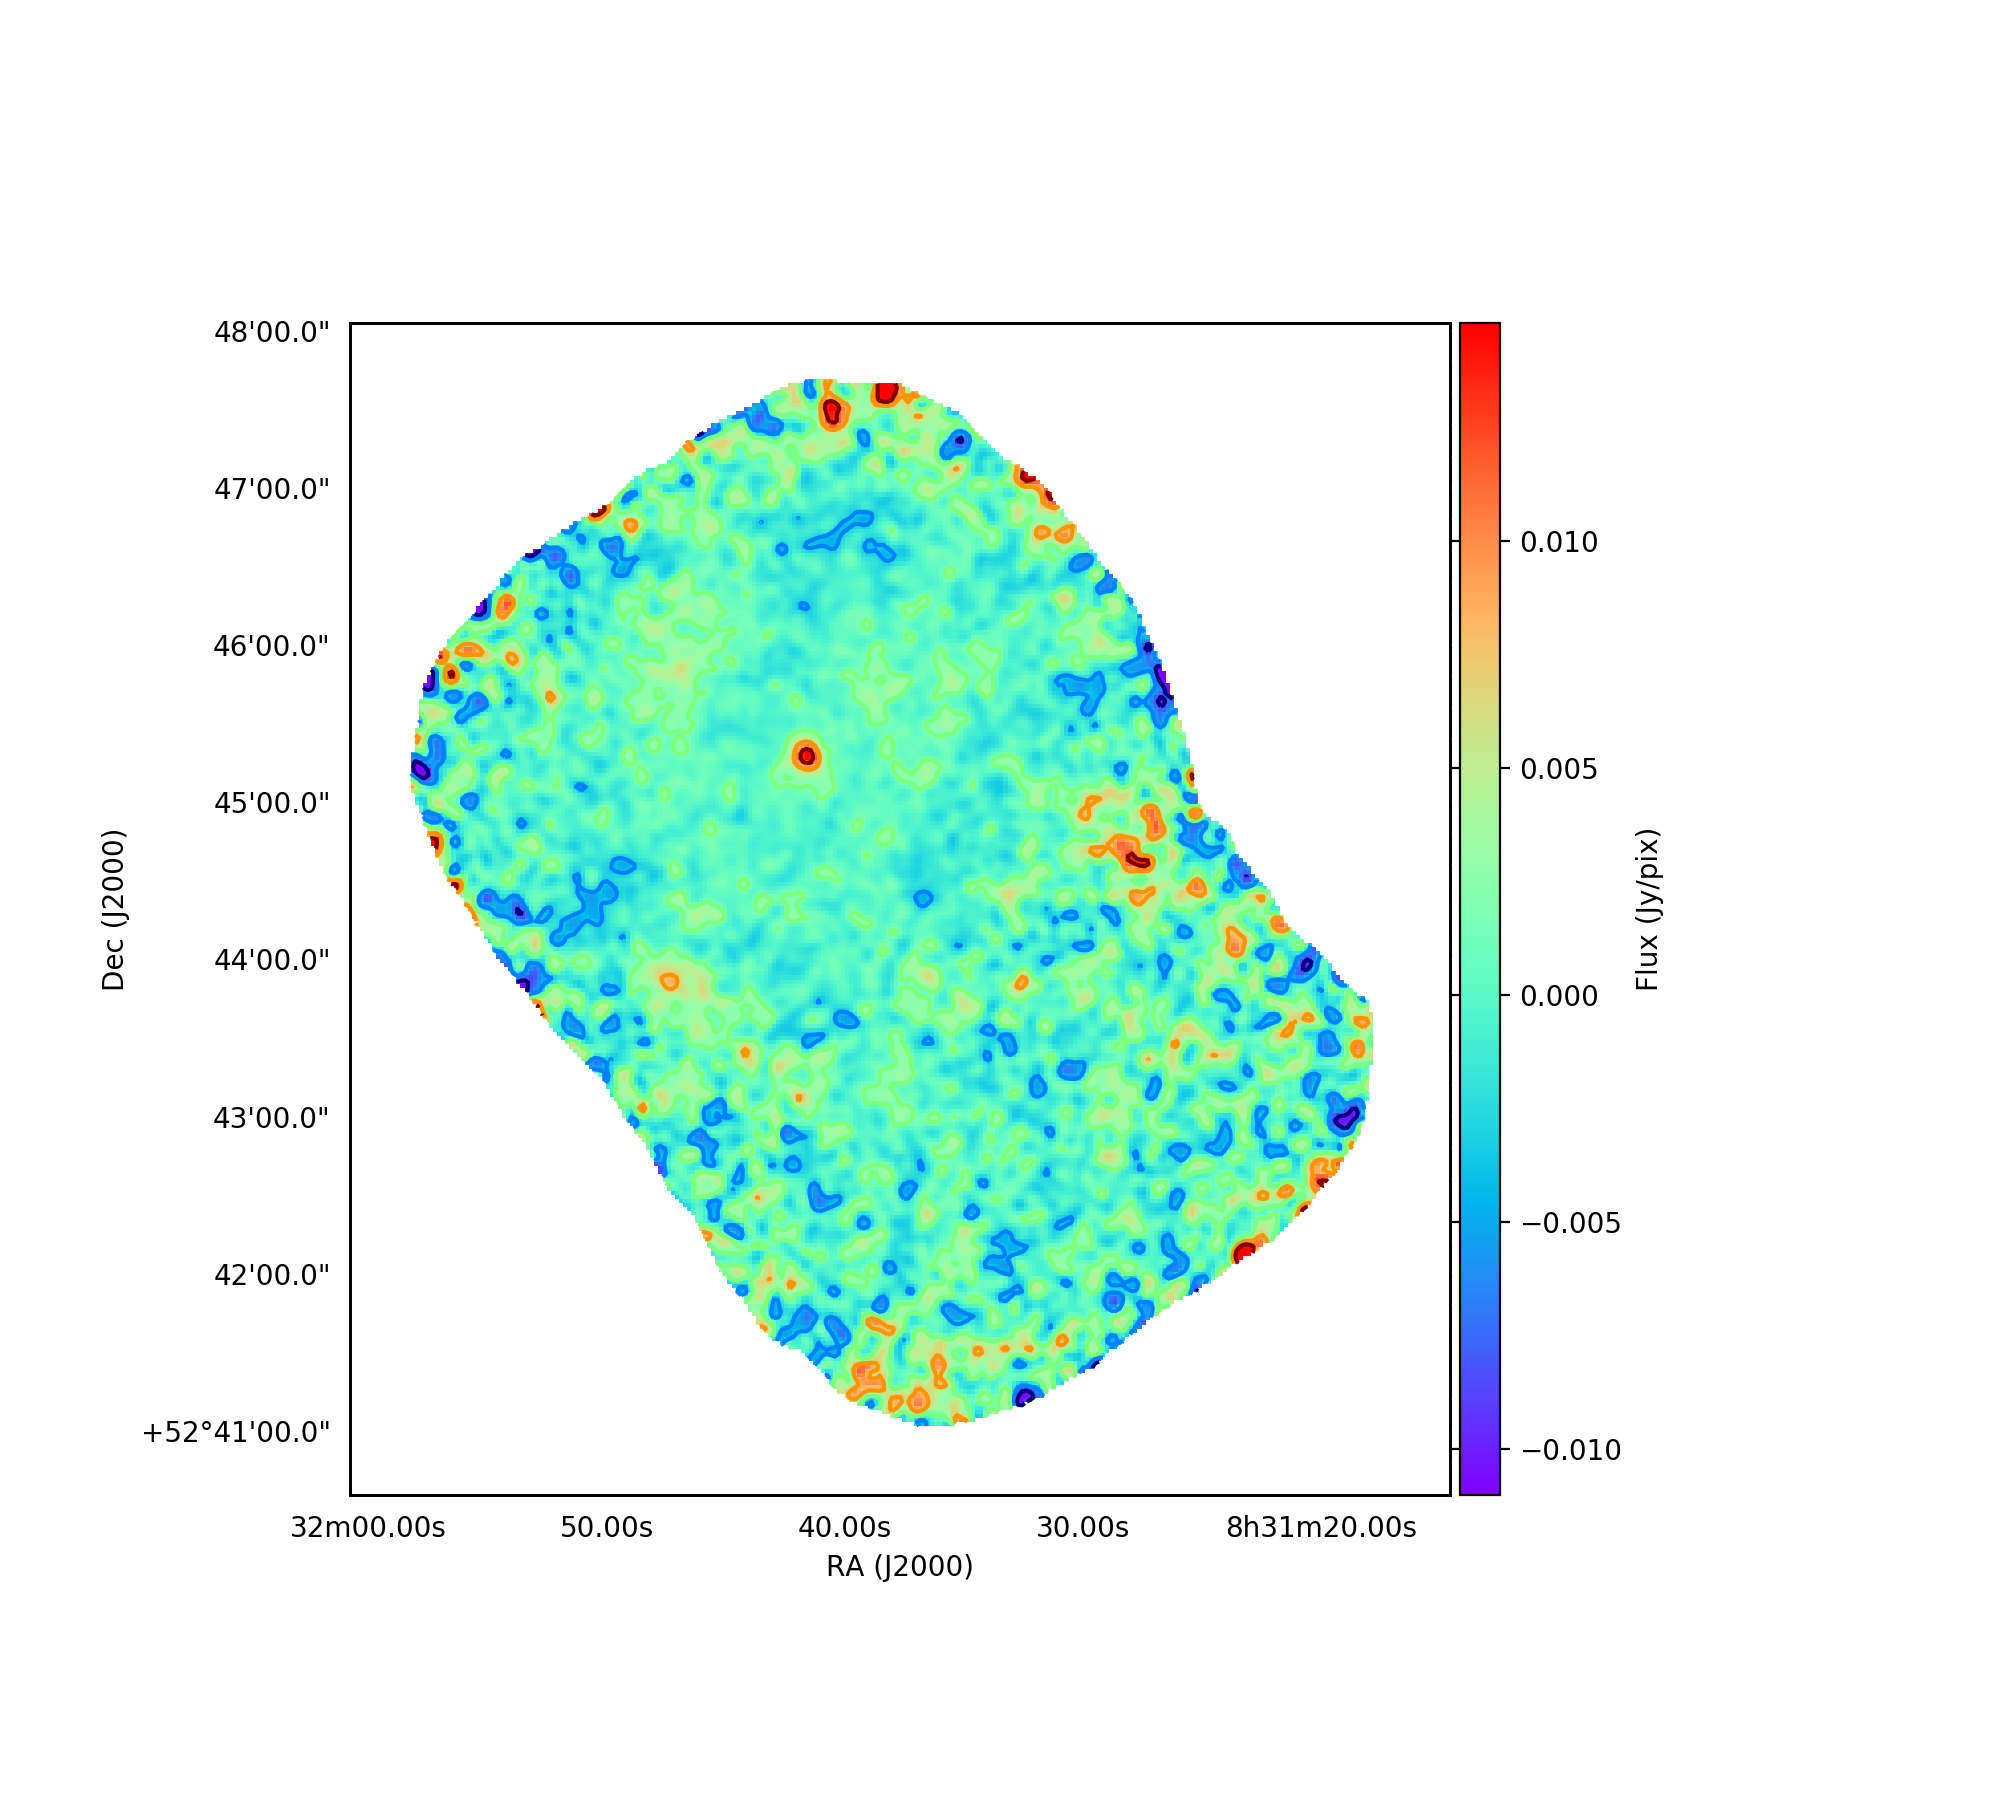

INFO: Auto-setting vmin to -1.101e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.482e-02 [aplpy.core]


/Users/rshuping/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:115: RuntimeWarning: invalid value encountered in less
  negative = result < 0.


In [5]:
import matplotlib
%matplotlib notebook
# ^jupyter magic for inline plots
#    leave this out if working in a non-interactive environment
from aplpy import FITSFigure

# set colormap for all plots
cmap = 'rainbow'

axs = FITSFigure(data_fits['PRIMARY IMAGE'])                # load HDU into aplpy figure
axs.show_colorscale(cmap=cmap)            # display the data with WCS projection and chosen colormap
axs.show_contour(data_fits['PRIMARY IMAGE'])

# Add colorbar
axs.add_colorbar()
axs.colorbar.set_axis_label_text('Flux (Jy/pix)')

<IPython.core.display.Javascript object>


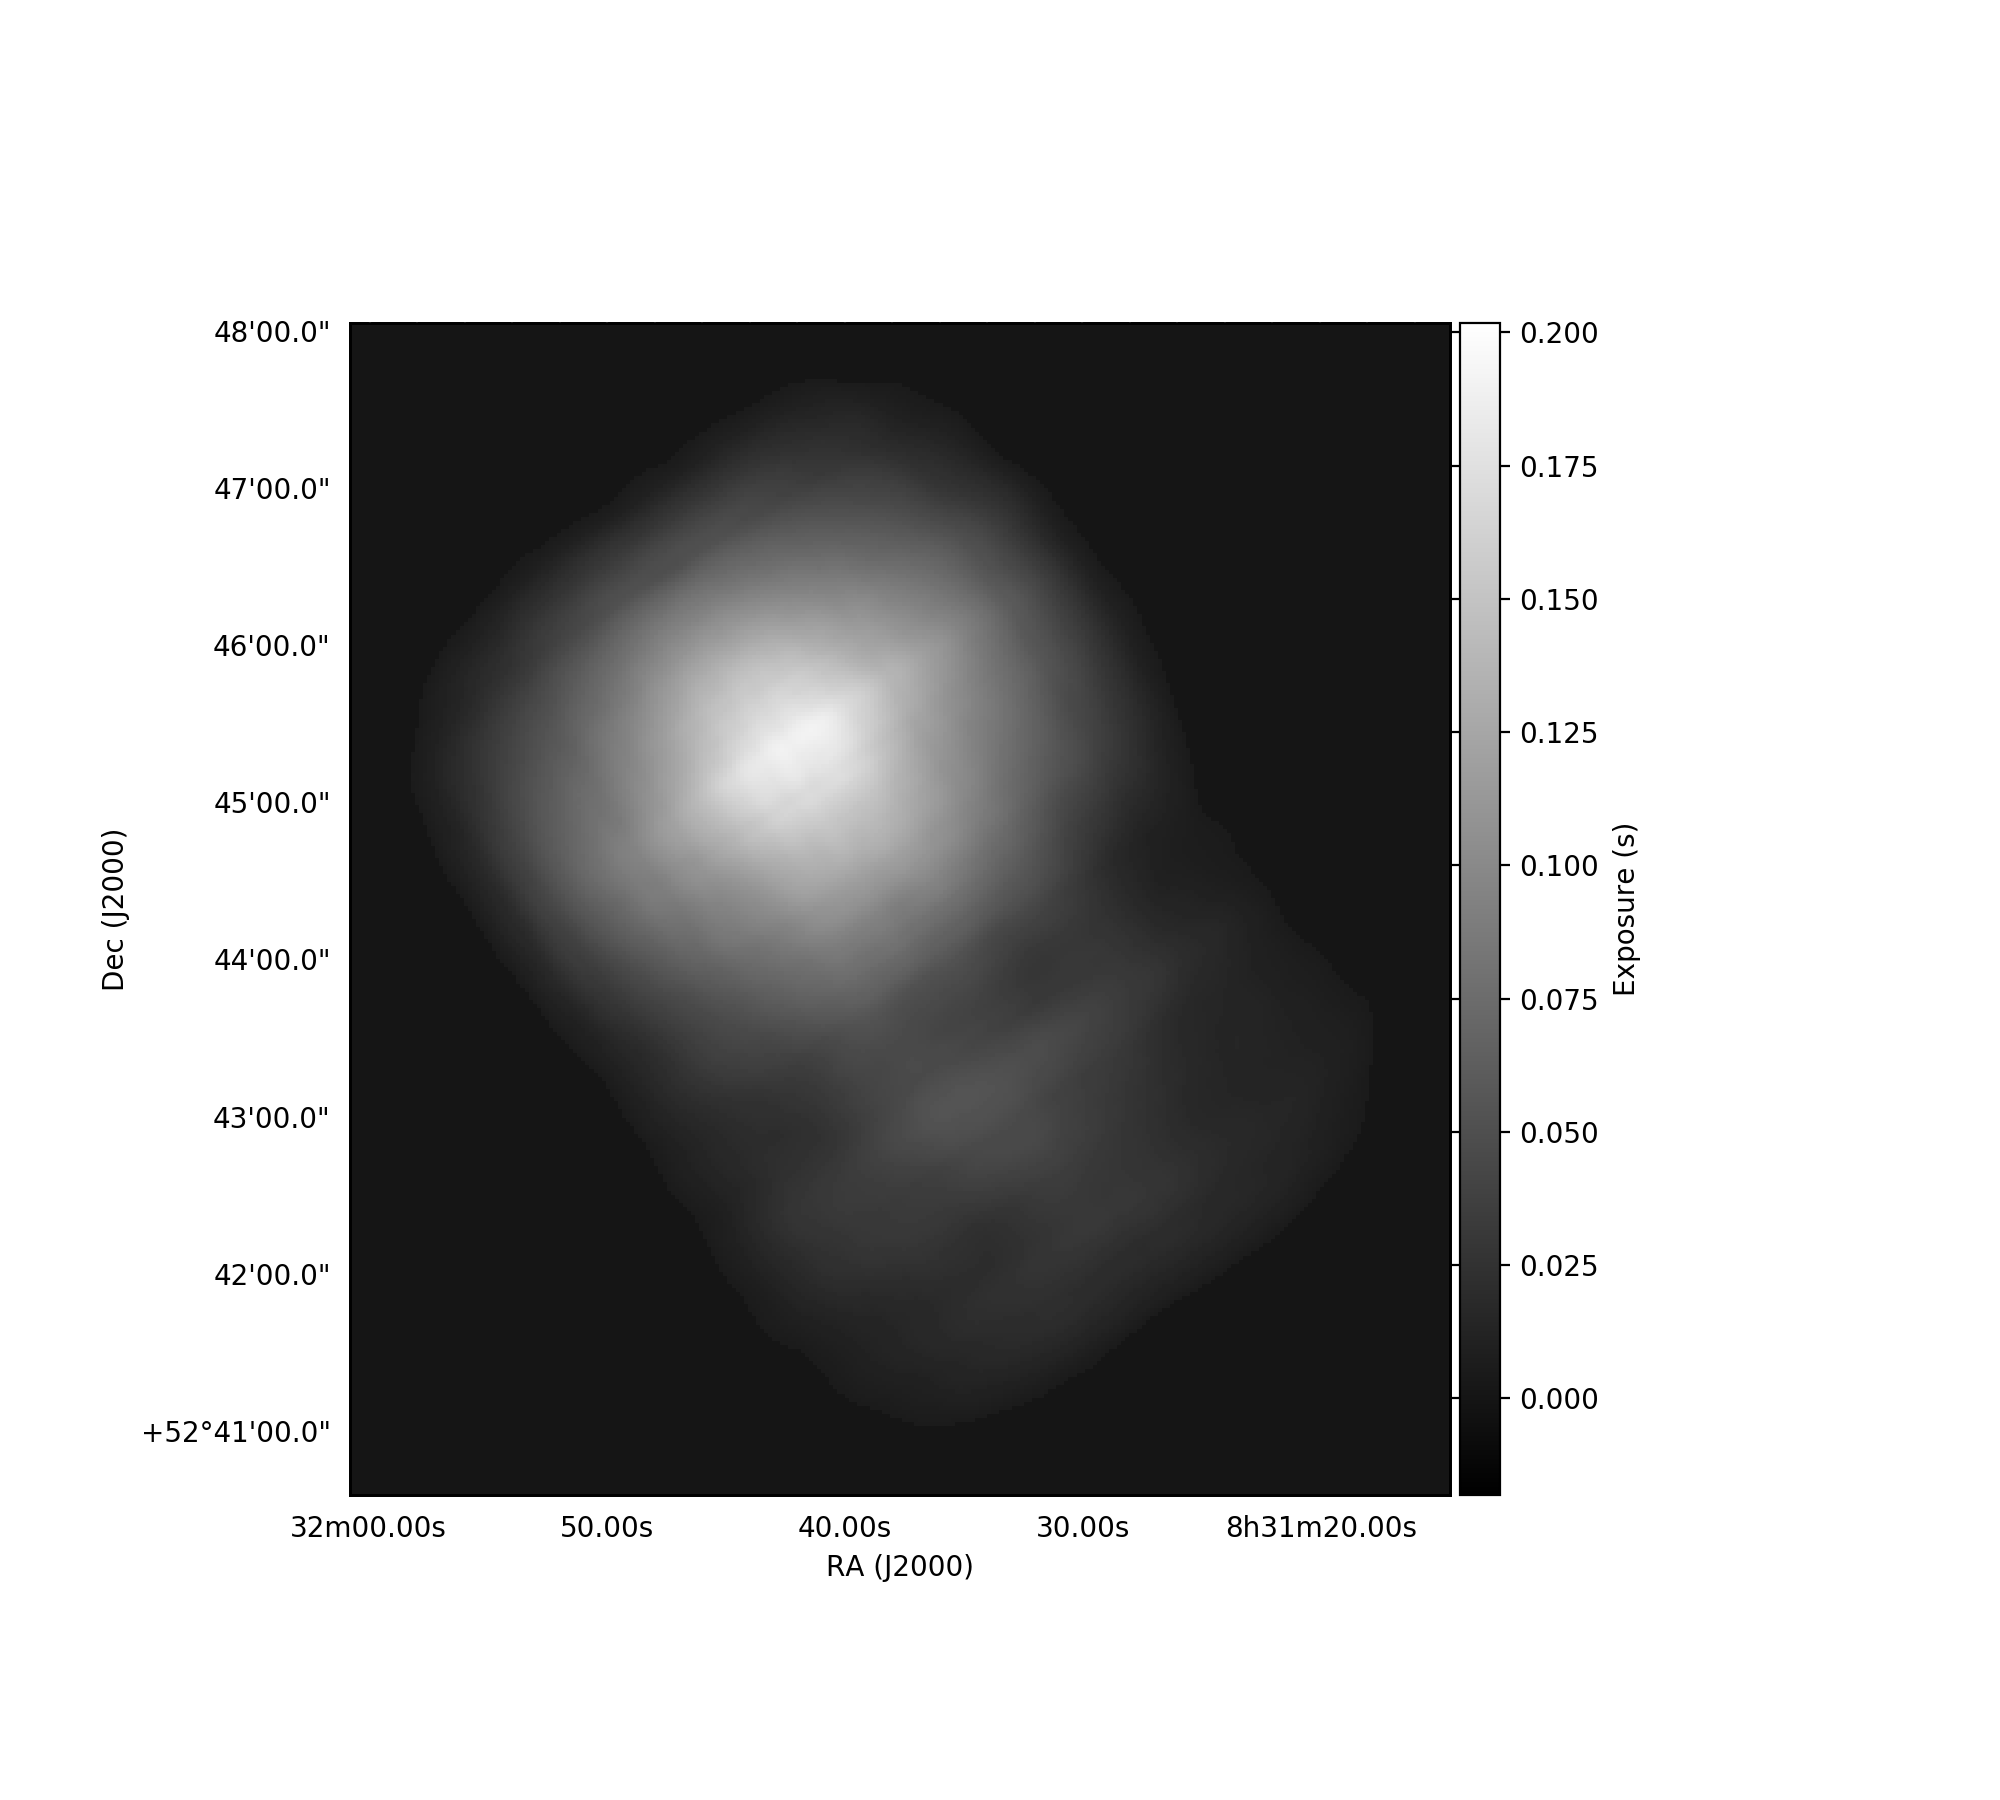

INFO: Auto-setting vmin to -1.818e-02 [aplpy.core]
INFO: Auto-setting vmax to  2.018e-01 [aplpy.core]


In [6]:
axs = FITSFigure(data_fits['EXPOSURE'])                # load HDU into aplpy figure
axs.show_grayscale()            # display the data with WCS projection and chosen colormap


# Add colorbar
axs.add_colorbar()
axs.colorbar.set_axis_label_text('Exposure (s)')

(MG:  Check units -- exposure times per pixel seem small.)

<IPython.core.display.Javascript object>


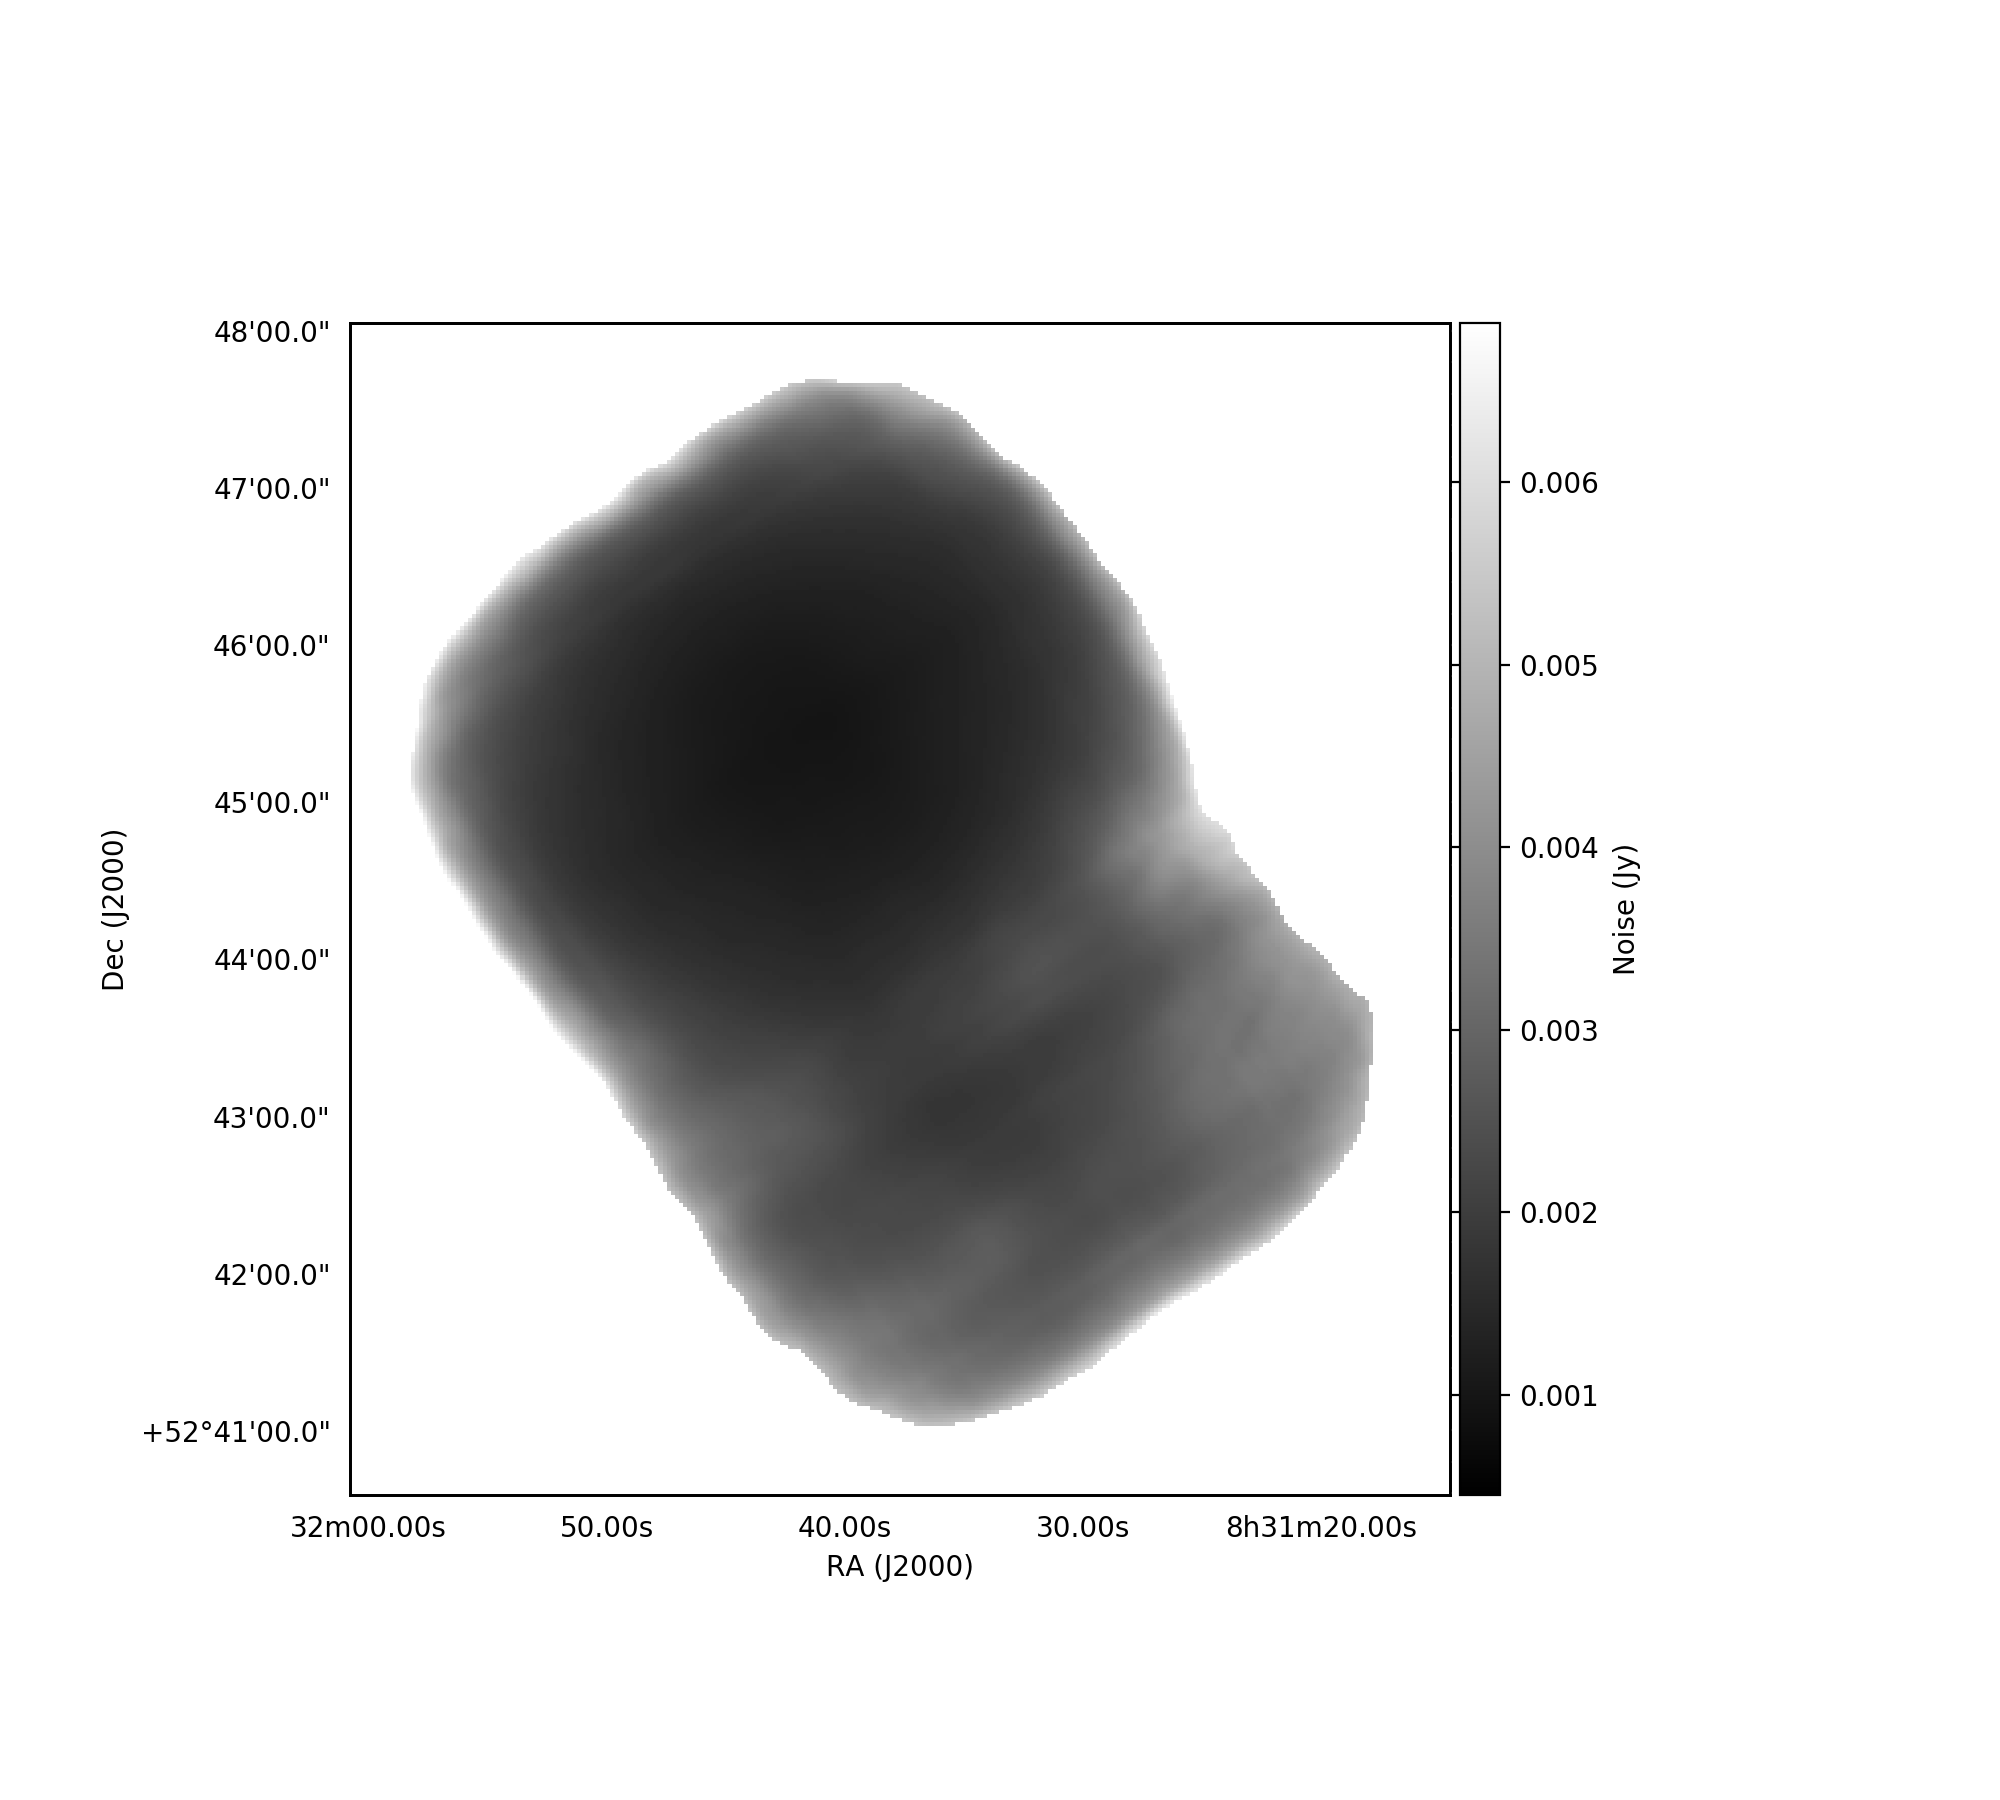

INFO: Auto-setting vmin to  4.495e-04 [aplpy.core]
INFO: Auto-setting vmax to  6.873e-03 [aplpy.core]


/Users/rshuping/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:115: RuntimeWarning: invalid value encountered in less
  negative = result < 0.


In [7]:
axs = FITSFigure(data_fits['NOISE'])                # load HDU into aplpy figure
axs.show_grayscale()            # display the data with WCS projection and chosen colormap

# Add colorbar
axs.add_colorbar()
axs.colorbar.set_axis_label_text('Noise (Jy)')

<IPython.core.display.Javascript object>


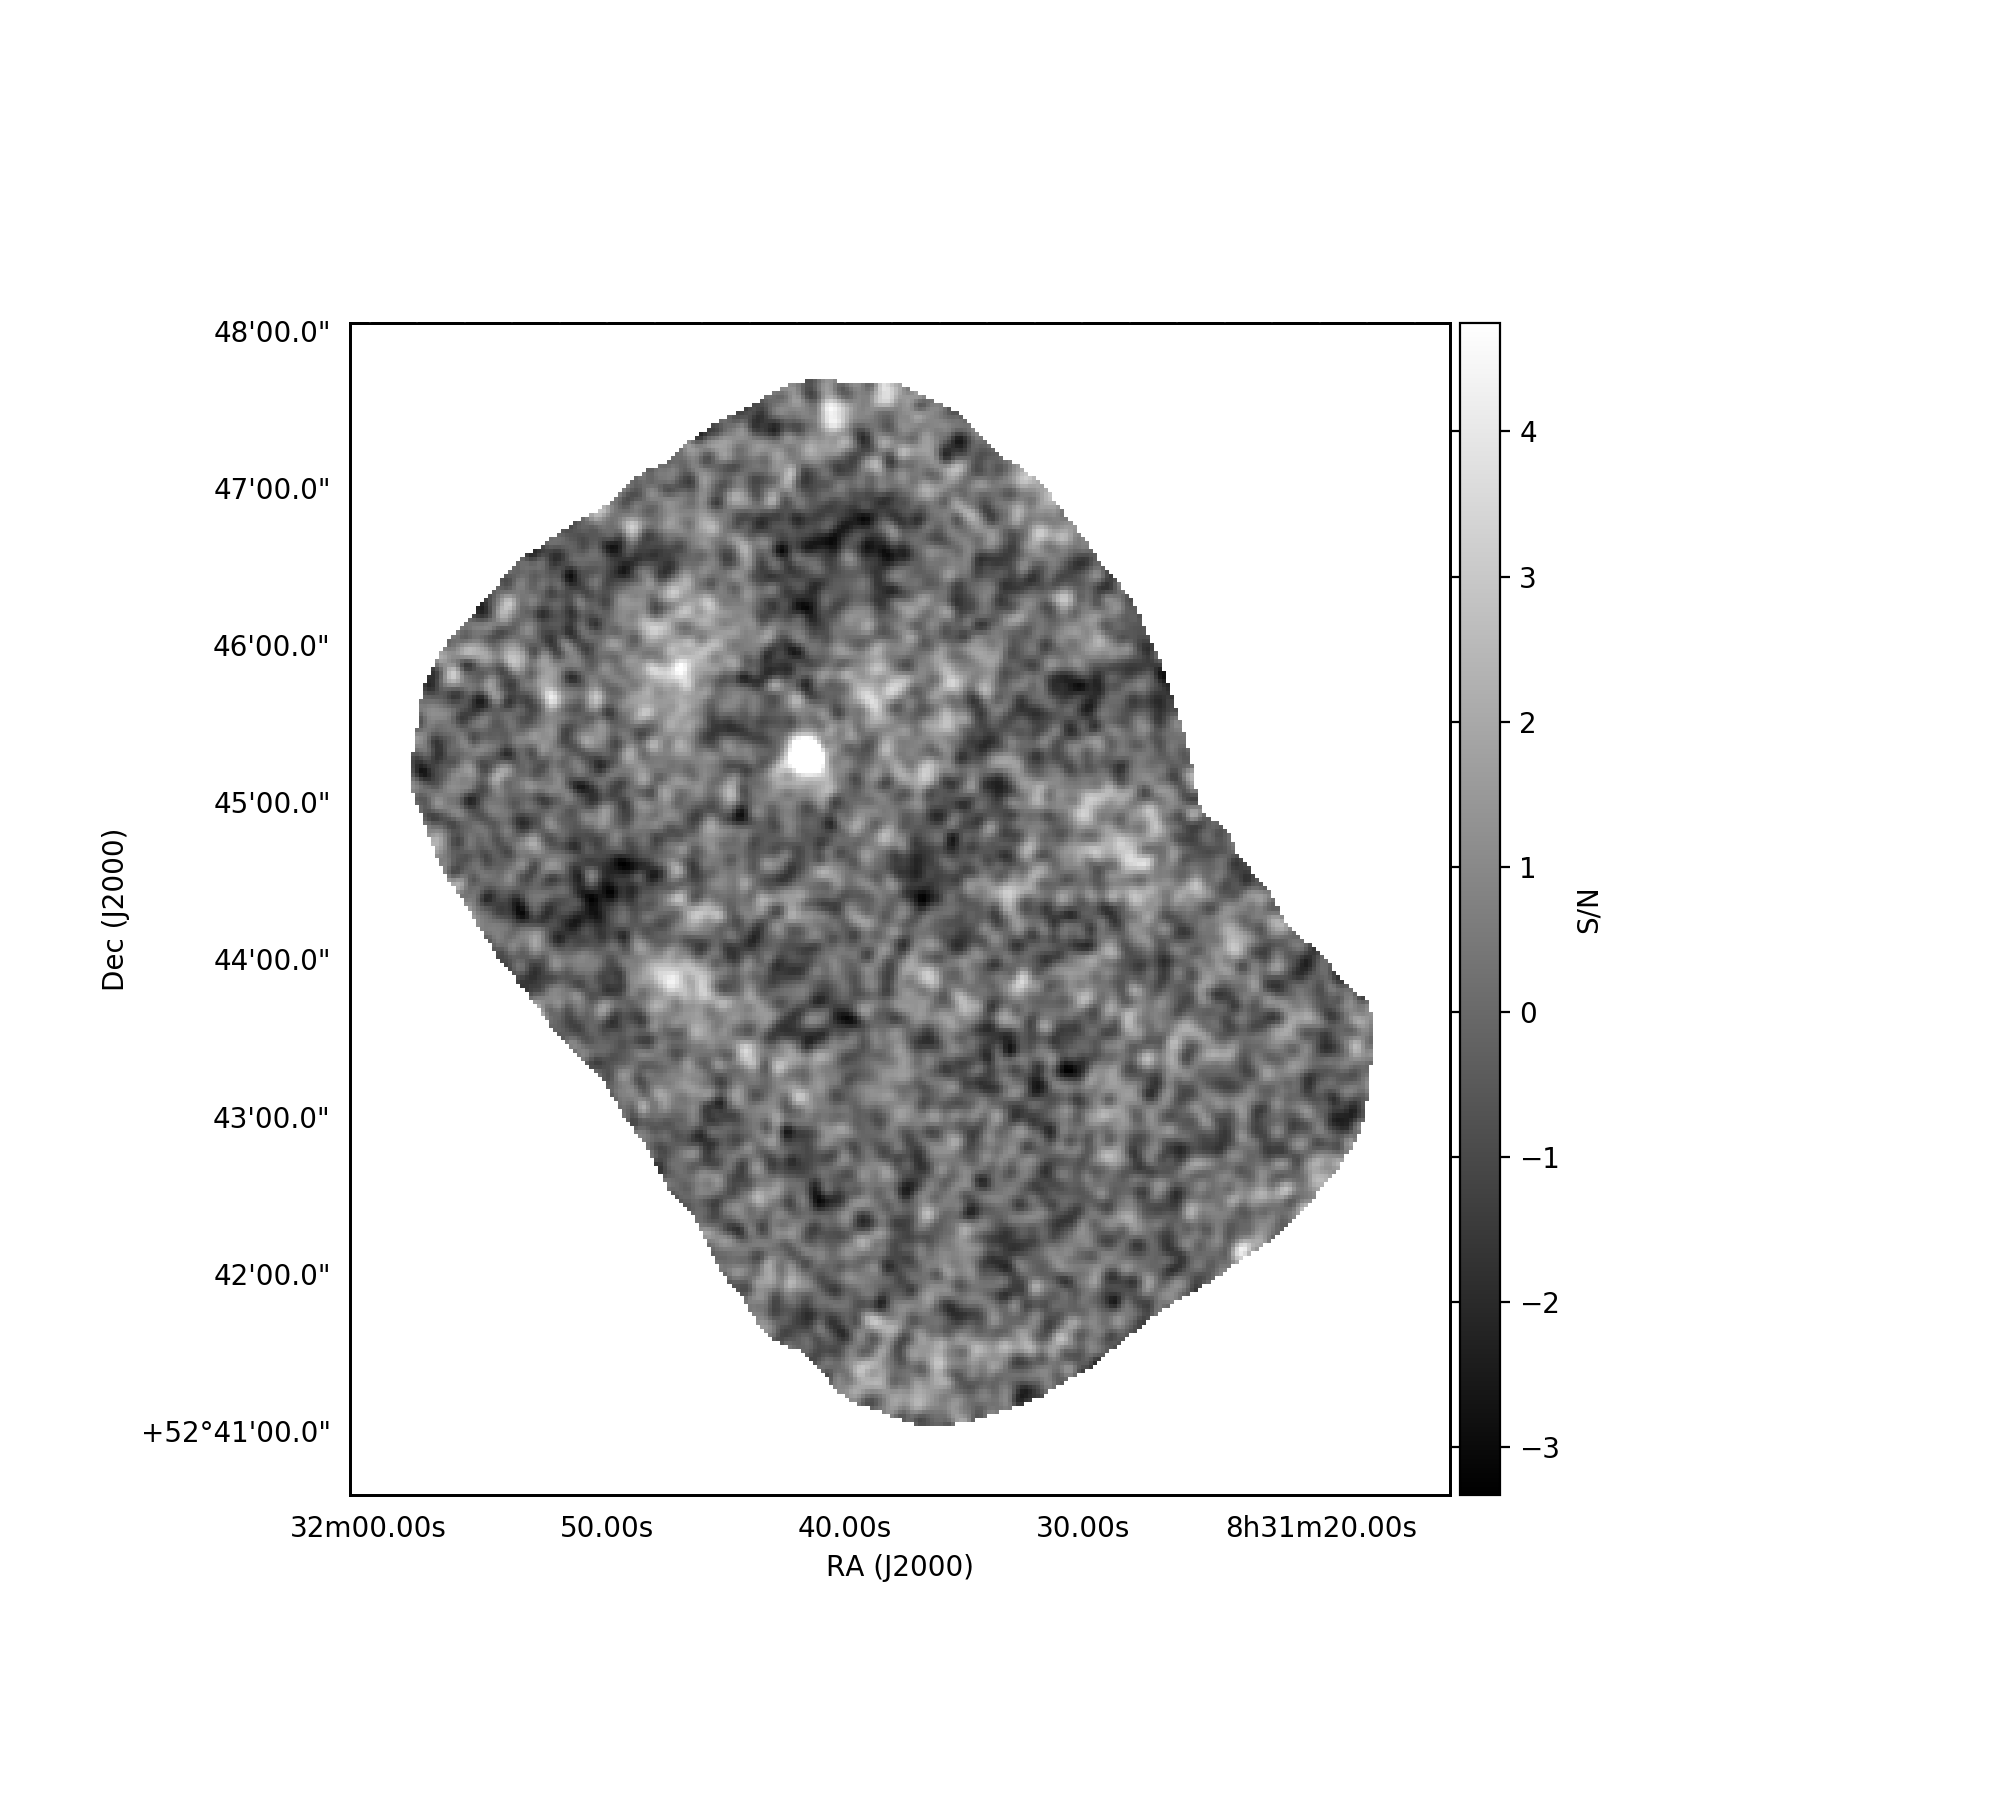

INFO: Auto-setting vmin to -3.336e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.750e+00 [aplpy.core]


/Users/rshuping/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:115: RuntimeWarning: invalid value encountered in less
  negative = result < 0.


In [8]:
axs = FITSFigure(data_fits['S/N'])                # load HDU into aplpy figure
axs.show_grayscale()            # display the data with WCS projection and chosen colormap

# Add colorbar
axs.add_colorbar()
axs.colorbar.set_axis_label_text('S/N')

(MG:  Need to explain negative values in S/N.)

You should be able to zoom, pan, and view pixel values for each image.  *AplPy* provides a wide array of options for displaying FITS images, see *AplPy* Documentation (https://aplpy.readthedocs.io/en/stable/) for more information.

## Background Estimation

First we will check the background statistics by using the *AstroPy* off-the-shelf (OTS) sigma clipping function (source masking can also be used). Plot a histogram as well to check the values.

(mean, median, stddev)
0.00032390164116681634 0.00027896277606487274 0.002328022842753355


<IPython.core.display.Javascript object>


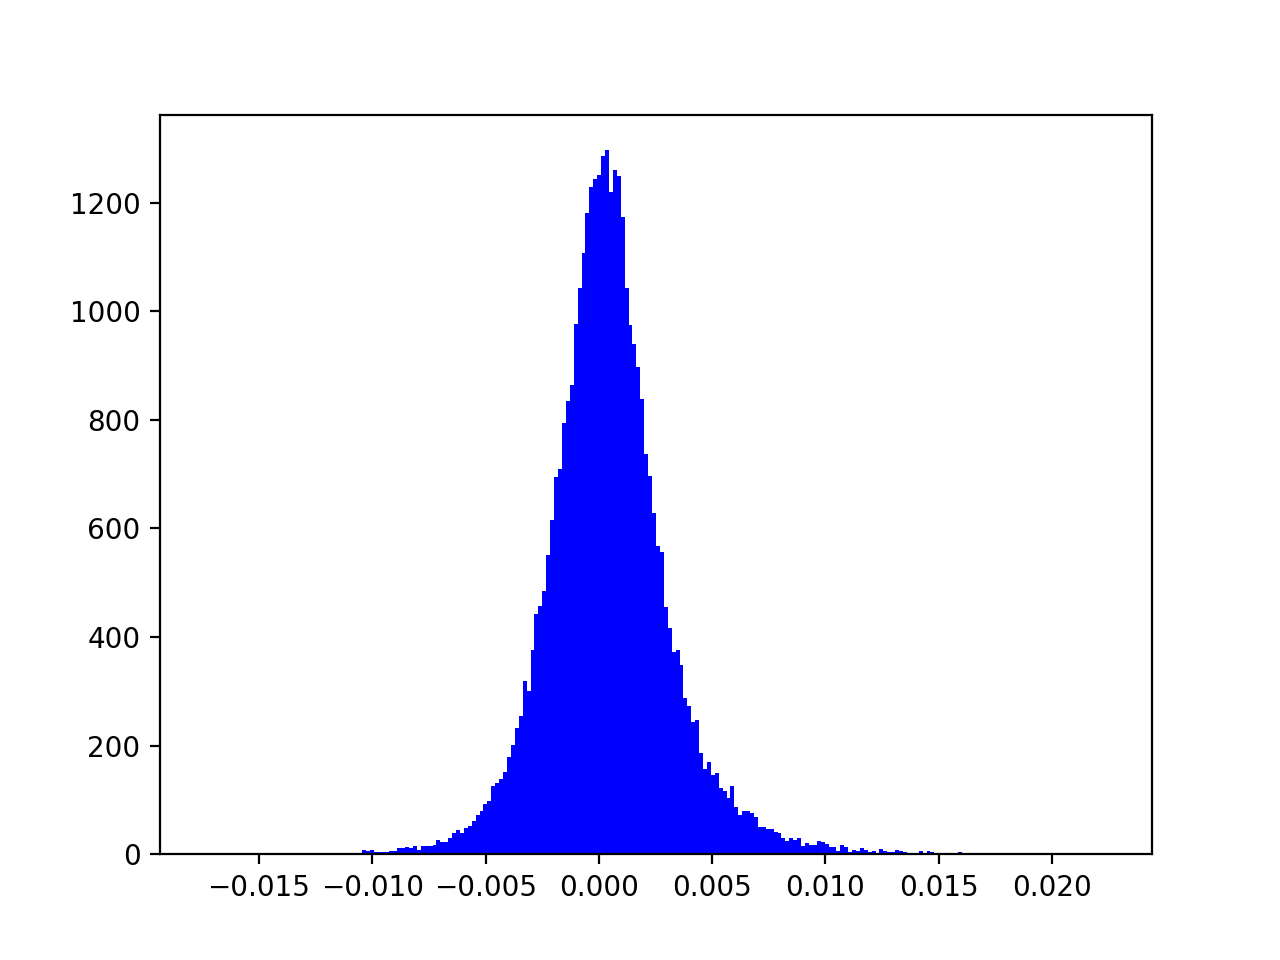

(array([1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        3.000e+00, 2.000e+00, 3.000e+00, 2.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 3.000e+00, 1.000e+00, 3.000e+00, 8.000e+00, 6.000e+00,
        9.000e+00, 5.000e+00, 5.000e+00, 5.000e+00, 5.000e+00, 6.000e+00,
        6.000e+00, 1.200e+01, 1.200e+01, 1.400e+01, 1.200e+01, 1.600e+01,
        8.000e+00, 1.500e+01, 1.600e+01, 1.500e+01, 1.800e+01, 2.600e+01,
        2.200e+01, 2.300e+01, 3.100e+01, 3.900e+01, 4.400e+01, 4.000e+01,
        4.800e+01, 5.200e+01, 6.100e+01, 7.300e+01, 8.000e+01, 9.300e+01,
        9.800e+01, 1.250e+02, 1.310e+02, 1.380e+02, 1.520e+02, 1.800e+02,
        2.010e+02, 2.330e+02, 2.540e+0

In [9]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from astropy.stats import sigma_clipped_stats as sigclip
from astropy import units as u

flux = data_fits[0].data   #read in flux values from primary HDU
flux_list = flux[np.logical_not(np.isnan(flux))]  #...and remove NANs to create a list of flux values.

#calculate mean, median, and stddev for flux list with clipping at 3-sigma:
mean, med, stddev = sigclip(flux_list, sigma=3.0)
print("(mean, median, stddev)")
print(mean, med, stddev)

plt.figure()
plt.hist(flux_list, bins='auto', facecolor='blue')

Since background correction is part of the HAWC+ pipeline, the mean and median should be close to zero (within the std dev).  If not, the user should probably contact the SOFIA Science Center to see if there is a systematic issue with the dataset.    

(MG:  IS there a systematic bias level in the background?  see below...)

## Source Detection and Centroiding

Before aperture photometry can be done we need to identify the location(s) of the source(s) in the field.  An easy way to do this is with the photutils find_peaks() function which simply finds all the local peaks in an image above a specified threshold (separated by a minimum number of pixels).  This can be done on the main flux image with some judicious masking to avoid edges, but it is much simpler to run find_peaks on the S/N image, which should not require any masking.  

In [10]:
from photutils import find_peaks

#define source detection threshold as median + 5-sigma
thresh = med + (5. * stddev)

#and define a mask over which to search for the peaks.
#In this case we will use a minimum exposure time (0.05s) to define the mask
exp = data_fits['EXPOSURE'].data  #load data from 1st HDU (EXPOSURE)
mask = exp < 0.05  #mask is a boolean area defining area to search for peaks

peaks = find_peaks(flux, thresh, box_size=11, mask=mask)  #returns a table structure
peaks['peak_value'].info.format = '%.8g'  # for consistent table output
print(peaks)


x_peak y_peak  peak_value
------ ------ -----------
   112    181 0.015010324


<IPython.core.display.Javascript object>


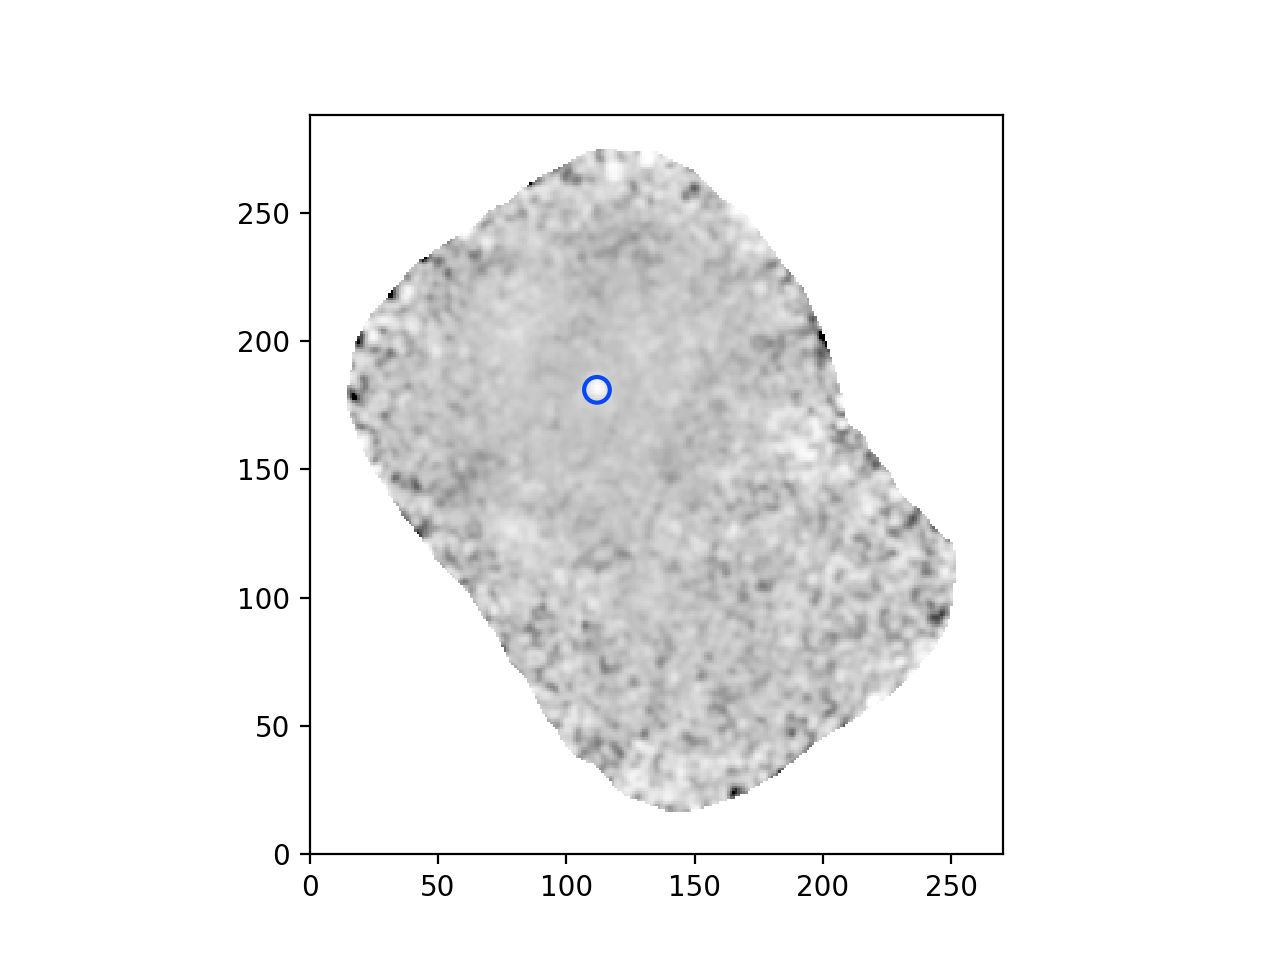

(0, 288)

In [11]:
from astropy.visualization import simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture as CircAp
positions = np.transpose((peaks['x_peak'], peaks['y_peak']))  #explain transpose funtion? 
apertures = CircAp(positions, r=5.)
norm = simple_norm(flux, 'sqrt', percent=99.9)

plt.figure()
plt.imshow(flux, cmap='Greys_r', origin='lower', norm=norm)
apertures.plot(color='#0547f9', lw=1.5)
plt.xlim(0, flux.shape[1]-1)
plt.ylim(0, flux.shape[0]-1)

In [12]:
#or use the S/N map
snr = data_fits['S/N'].data  #load data from 3rd HDU (S/N)

#define source detection threshold 5-sigma
thresh = 5.

#and define a mask over which to search for the peaks.
#In this case we will use a minimum exposure time (0.05s) to define the mask
#exp = bandc_fits['EXPOSURE'].data  #load data from 1st HDU (EXPOSURE)
#mask = exp < 0.05  #mask is a boolean area defining area to search for peaks

peaks = find_peaks(snr, thresh, box_size=11)  #returns a table structure
peaks['peak_value'].info.format = '%.8g'  # for consistent table output
print(peaks)

x_peak y_peak peak_value
------ ------ ----------
   112    182  15.129399
    81    203  5.0391769


<IPython.core.display.Javascript object>


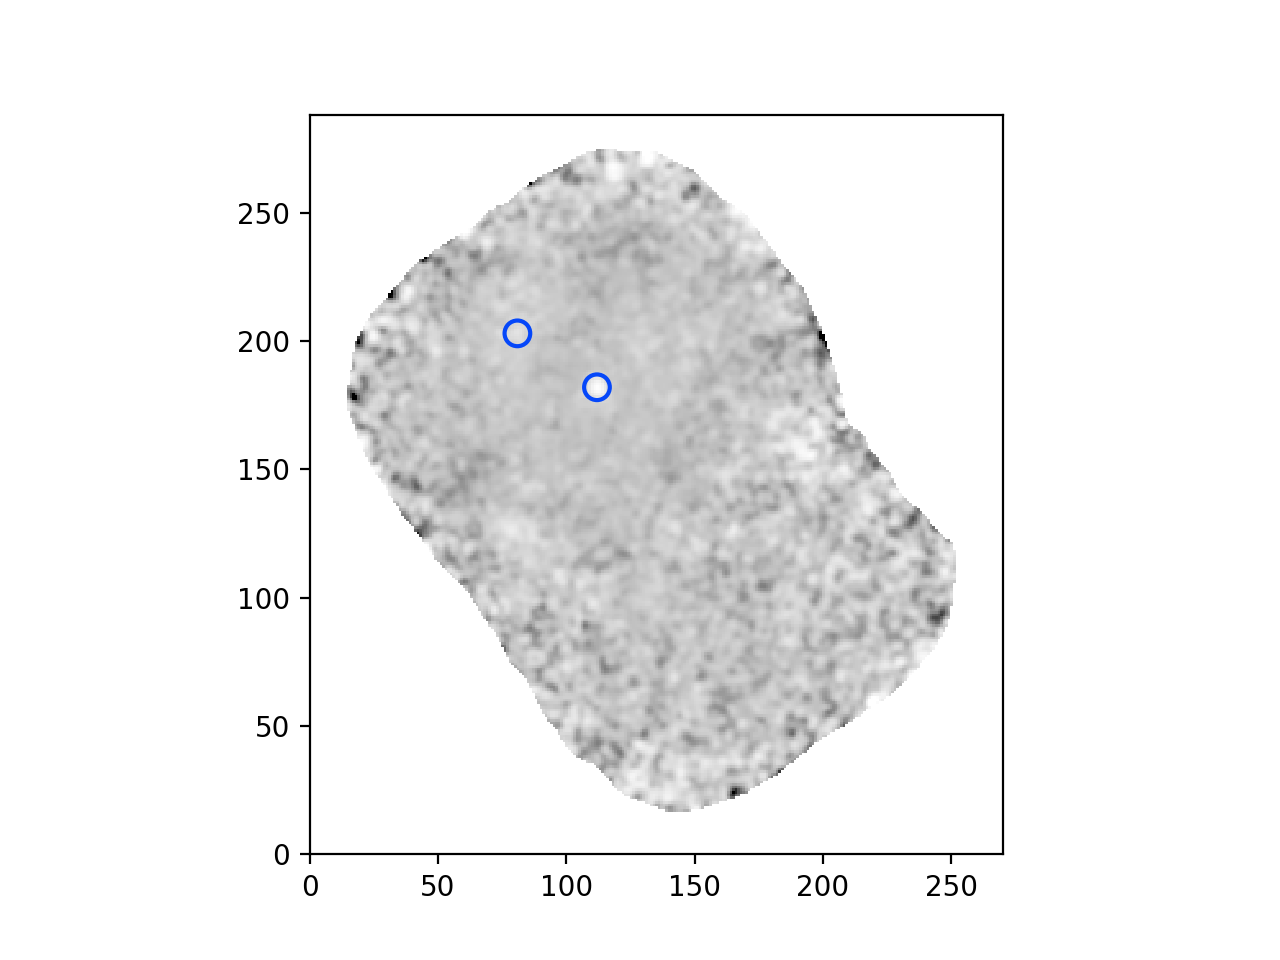

(0, 288)

In [13]:
positions = np.transpose((peaks['x_peak'], peaks['y_peak']))
apertures = CircAp(positions, r=5.)
norm = simple_norm(flux, 'sqrt', percent=99.9)

plt.figure()
plt.imshow(flux, cmap='Greys_r', origin='lower', norm=norm)
apertures.plot(color='#0547f9', lw=1.5)
plt.xlim(0, flux.shape[1]-1)
plt.ylim(0, flux.shape[0]-1)

Here the find_peaks algorithm has picked up what looks like some diffuse signal that is probably due to instrumental artifacts (TBC).

## Aperture Photometry

We'll now perform simple aperture photometry on the main source in the image following the guide in the photutils documentation (https://photutils.readthedocs.io/en/stable/aperture.html).

TBD:  need standard aperture from HAWC+ flux calibration.

In [14]:
#First define a simple aperture with radius of 15 pixels using centroid from peak finder.
from photutils import aperture_photometry as ap_phot
posn = list(peaks[0]['x_peak','y_peak'])  #need to convert peaks table to an array or list
ap = CircAp(posn, r=15.)
print(ap)


Aperture: CircularAperture
positions: [[112, 182]]
r: 15.0


In [15]:
#assign units to flux array
flux = flux * u.Jy

#now do the photometry
phot_table = ap_phot(flux, ap)
phot_table['aperture_sum'].info.format = '%.8g'  # for consistent table output
phot_table

id,xcenter,ycenter,aperture_sum
,pix,pix,Jy
int64,float64,float64,float64
1,112.0,182.0,0.97816537


In [16]:
#Can also do multiple apertures....
radii = [5., 7., 9., 11., 13., 15., 17., 19., 21.]
aps = [CircAp(posn, r=r) for r in radii]
phot_table = ap_phot(flux, aps)
phot_table

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,aperture_sum_2,aperture_sum_3,aperture_sum_4,aperture_sum_5,aperture_sum_6,aperture_sum_7,aperture_sum_8
,pix,pix,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,112.0,182.0,0.5789270427752105,0.7389451268026496,0.8454812054072394,0.9361006318942677,0.9876564843897929,0.9781653721021406,0.9657996890759338,1.0199202119842896,1.136428620602488


Since the residual background is usually significant, it is necessary to measure the background local to the source, usually in an annulus just outside the source aperture,  and subtract it from the measurement in the source aperture.  

<IPython.core.display.Javascript object>


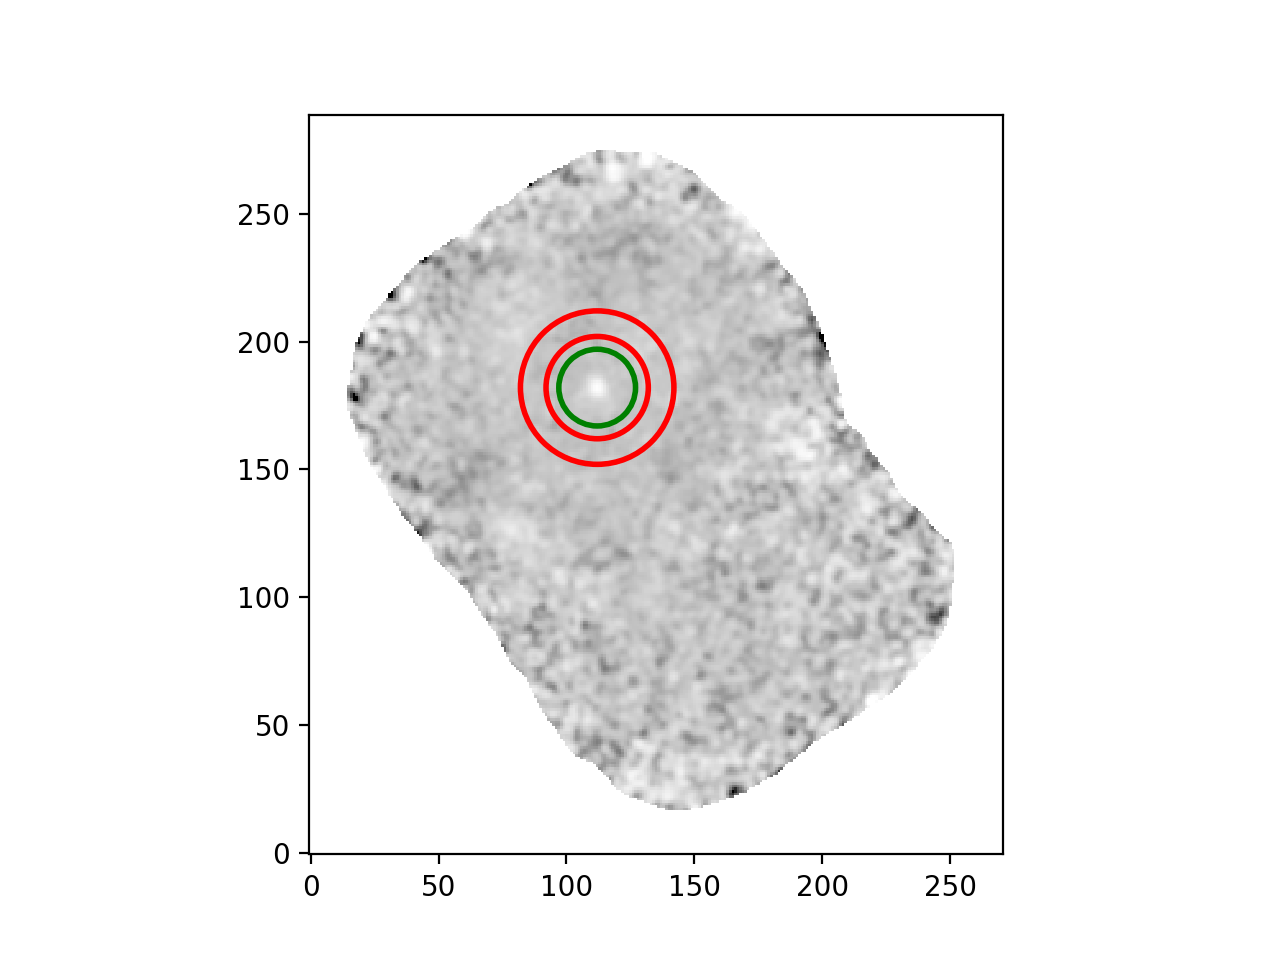

In [17]:
#Now find background in an annulus
#First define annulus
from photutils import CircularAnnulus as CircAnn
annulus_ap = CircAnn(posn, r_in=20, r_out=30)

#now plot aperture and annulus togehter on image just to check:
from astropy.visualization import simple_norm

plt.figure()
#norm = simple_norm(flux, 'sqrt', percent=99)
plt.imshow(flux, cmap='Greys_r', origin='lower', norm=norm)
ap.plot(color='green', lw=2)
annulus_ap.plot(color='red', lw=2)
#plt.xlim(0, 170)
#plt.ylim(130, 250)

In [18]:
#Now do summation in both source and background apertures.
aps = [ap, annulus_ap] 
phot_table = ap_phot(flux, aps)
phot_table

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1
,pix,pix,Jy,Jy
int64,float64,float64,float64,float64
1,112.0,182.0,0.9781653721021406,0.638895229637452


In [19]:
#now calculate mean residual background per pixel:
#aperture_sum_1 / annulus area
bkg_mean = phot_table['aperture_sum_1'] / annulus_ap.area()

#And subtract off the total background in the circular aperture to get the measured flux:
flux_m = phot_table['aperture_sum_0'] - (bkg_mean *ap.area())

print('Mean background per pixel:', bkg_mean)
print('Background subtracted flux:', flux_m)

Mean background per pixel: [0.00040673] Jy
Background subtracted flux: [0.69066252] Jy


Notice that since we are using very large apertures, even a small residual per pixel results in a large correction to the flux.

To estimate the error in the flux measurement, we can use the noise image included with the HAWC+ data as the "background error image" in phot utils.

In [20]:
#First read in noise image and assign units:
error = data_fits['NOISE'].data * u.Jy

#and now simply plug it into ap_phot with the error keyword
phot_table = ap_phot(flux, aps, error=error)
phot_table.show_in_notebook()

idx,id,xcenter,ycenter,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1
,,pix,pix,Jy,Jy,Jy,Jy
0,1,112.0,182.0,0.9781653721021406,0.026878172488073677,0.638895229637452,0.04469908698018751


Note that the actual error in the background for the circular aperture is the error in the annulus scaled by the ratio of the aperture areas, and should be very close to the error in the circualr aperture.  The final *measurment* error is just the circular aperture error and the scaled background error added in quadrature.  The final error does *not* include calibration error (see below).

In [21]:
#now calculate mean residual background per pixel:
#aperture_sum_1 / annulus area
bkg_mean = phot_table['aperture_sum_1'] / annulus_ap.area()

#And subtract off the total background in the circular aperture to get the measured flux:
flux_m = phot_table['aperture_sum_0'] - (bkg_mean *ap.area())

#compute error in background for the circular aperture:
bkg_err = phot_table['aperture_sum_err_1']*ap.area()/annulus_ap.area()

#Now we can add the errors in  quadrature for a final estimate of the *measurement* error.
#This does not include the flux calibration error.
sigma_m = np.sqrt(phot_table['aperture_sum_err_0']**2 + bkg_err**2)

#and add to the table for completeness
phot_table['Measured Flux'] = flux_m
phot_table['Uncertainty'] = sigma_m
phot_table['S/N'] = flux_m/sigma_m
phot_table.show_in_notebook()

idx,id,xcenter,ycenter,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,Measured Flux,Uncertainty,S/N
,,pix,pix,Jy,Jy,Jy,Jy,Jy,Jy,
0,1,112.0,182.0,0.9781653721021406,0.026878172488073677,0.638895229637452,0.04469908698018751,0.6906625187652872,0.03357130996272368,20.572998775805083


Now we need to apply the color correction, $K$, for the given filter to obtain the true object flux at the filter reference wavelength, $F_{\nu}(\lambda_{ref})$:

$F_{\nu}(\lambda_{ref}) = F^{*}_{\nu} / K$  

Where $F^{*}_{\nu}$ is the *measured* source flux for the given filter, and $K$ is the color correction which depends on the bandpass and the spectral shape of the source. HAWC+ $K$ values and isophotal wavelengths for a range of blackbody temperatures and power-law slopes are tabulated here:

https://www.sofia.usra.edu/sites/default/files/Instruments/HAWC_PLUS/Documents/HAWC_ColorCorrecns_OC5.pdf

along with reference wavelengths for each band.

(TBD:  create table structure as part of this recipe?)

For our Band C data, we'll assume our source is a blackbody with $T=$500K.  The reference (mean) wavelength for Band C is 89.305 micron.   We'll simply add these values to the photometry table above along with the corrected flux $F_{\nu}(\lambda_{ref})$.

In [22]:
#Read K value and reference wavelength from color correction tables.
k_cc =  1.034
lambda_ref = 89.305 * u.micron

phot_table['lambda_ref'] = lambda_ref
phot_table['K correction'] = k_cc
phot_table['Object Flux'] = phot_table['Measured Flux'] / k_cc
phot_table.show_in_notebook()

idx,id,xcenter,ycenter,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,Measured Flux,Uncertainty,S/N,lambda_ref,K correction,Object Flux
,,pix,pix,Jy,Jy,Jy,Jy,Jy,Jy,,micron,,Jy
0,1,112.0,182.0,0.9781653721021406,0.026878172488073677,0.638895229637452,0.04469908698018751,0.6906625187652872,0.03357130996272368,20.572998775805083,89.305,1.034,0.6679521458078213


The total uncertainty in the flux is the measurement uncertainty (above) added to the calibration uncertainty in quadrature:

$\sigma_{tot}^2 = \sigma_{m}^2 + \sigma_{cal}^2$

where $\sigma_m$ and $\sigma_c$ are the measurement and calibration errors respectively.  According to the HAWC+ Data Handbook, the calibration uncertainty is apporximately 10% for all bands.  We'll add the total uncertainty to the table as well:

In [23]:
#Calculate total uncertainty by adding measurement uncertainty to calibration uncertainy in quadrature:
relerr_cal = 0.1

phot_table['Total Uncertainty'] = np.sqrt(phot_table['Uncertainty']**2 + (relerr_cal*phot_table['Object Flux'])**2)
phot_table.show_in_notebook()

idx,id,xcenter,ycenter,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,Measured Flux,Uncertainty,S/N,lambda_ref,K correction,Object Flux,Total Uncertainty
,,pix,pix,Jy,Jy,Jy,Jy,Jy,Jy,,micron,,Jy,Jy
0,1,112.0,182.0,0.9781653721021406,0.026878172488073677,0.638895229637452,0.04469908698018751,0.6906625187652872,0.03357130996272368,20.572998775805083,89.305,1.034,0.6679521458078213,0.07475716382732828
